In [1]:
# widen jupyter notebook window
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:90% !important; }</style>"))

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from numba import njit, jit, prange

In [55]:
import sys
sys.path.append('/media/rich/Home_Linux_partition/github_repos/')

%load_ext autoreload
%autoreload 2
from basic_neural_processing_modules import pickle_helpers, misc, parallel_helpers, timeSeries, torch_helpers, plotting_helpers

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
masks = pickle_helpers.simple_load(r'/media/rich/bigSSD/other lab data/Tolias lab/ROI_data/masks.pkl')

In [5]:
# @jax.jit
def center_of_mass(image):
    weights = np.mean(image, axis=0)
    com_x = np.sum(np.arange(image.shape[1]) * weights) / np.sum(weights)
    weights = np.mean(image, axis=1)
    com_y = np.sum(np.arange(image.shape[0]) * weights) / np.sum(weights)
    return com_x, com_y

In [6]:
from time import time
from tqdm.notebook import tqdm, trange

In [7]:
len(masks)

8526013

In [ ]:
idx_masks = np.arange(len(masks))
out_height_width = [36,36]
max_footprint_width = 241
plot_pref = True
batch_size = 1000

tic = time()

# def extract_rois(idx_masks, out_height_width, max_footprint_width, plot_pref):
assert out_height_width[0]%2 == 0 and out_height_width[1]%2 == 0 , "RH: 'out_height_width' must be list of 2 EVEN integers"
assert max_footprint_width%2 != 0 , "RH: 'max_footprint_width' must be odd"


# sf_big: 'spatial footprints' prior to cropping. sf is after cropping
sf_big_width = max_footprint_width # make odd number
sf_big_mid = sf_big_width // 2

n_roi = len(idx_masks)

pixels = list(masks.iloc[idx_masks]['pixels'])

weights_np = list(masks.iloc[idx_masks]['weights'])
weights = [torch.as_tensor(weights_np[ii], dtype=torch.float32) for ii in range(len(pixels_np))]
px_height = list(masks.iloc[idx_masks]['px_height'])
px_width = list(masks.iloc[idx_masks]['px_width'])

#     good_masks = np.ones(n_roi)

In [ ]:
sf = torch.zeros((len(pixels), out_height_width[0], out_height_width[1]), dtype=torch.float32)
for ii in trange(len(pixels)):
#         print(pixels[ii])
    idx_pixels = np.unravel_index(pixels[ii],
                        shape=(px_height[ii], px_width[ii]),
                        order='F')

    tmp_im = np.zeros((px_height[ii], px_width[ii]))
    tmp_im[idx_pixels] = weights[ii]
    center_x, center_y = np.int64(center_of_mass(tmp_im))

    if (center_x < out_height_width[1]//2) or (px_width[ii] - center_x < out_height_width[1]//2):
#             good_masks[ii] = 0
        continue
    if (center_y < out_height_width[0]//2) or (px_height[ii] - center_y < out_height_width[0]//2):
#             good_masks[ii] = 0
        continue

    try:
        sf_big = torch.zeros((sf_big_width, sf_big_width), dtype=torch.float32)
        sf_big[idx_pixels[0] - center_y + sf_big_mid, idx_pixels[1] - center_x + sf_big_mid] = weights[ii] / torch.sum(weights[ii])
        sf[ii] = sf_big[sf_big_mid - out_height_width[0]//2:sf_big_mid + out_height_width[0]//2,
                        sf_big_mid - out_height_width[1]//2:sf_big_mid + out_height_width[1]//2] # (dim0: ROI#) (dim1: y pix) (dim2: x pix)
    except:
#             print(f'roi: {ii} was too big and will be all zeros')
#             good_masks[ii] = 0
        continue
    

3171.33486700058


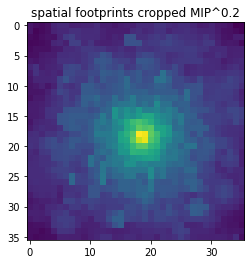

In [35]:
if plot_pref:
    plt.figure()
    plt.imshow(torch.max(sf, dim=0)[0]**0.2)
    plt.title('spatial footprints cropped MIP^0.2')
#     return sf

print(time() - tic)

In [46]:
misc.estimate_size_of_float_array(sf)/1000000000

0.10368

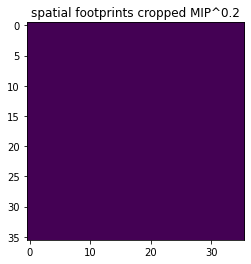

In [47]:
if plot_pref:
    plt.figure()
    plt.imshow(np.max(sf, axis=0)**1)
    plt.title('spatial footprints cropped MIP^0.2')

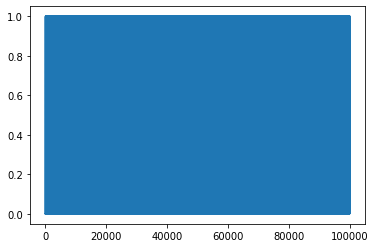

In [14]:
plt.figure()
plt.plot(np.sum(sf, axis=(1,2)))

<IPython.core.display.Javascript object>


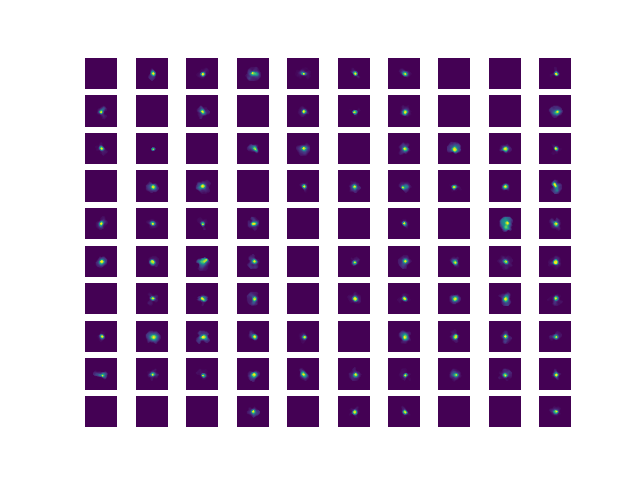

In [73]:
%matplotlib notebook

fig, axs = plt.subplots(10,10)
idx_axs = plotting_helpers.get_subplot_indices(axs)
for i_ax, idx_ax in enumerate(idx_axs):
#     print(idx_ax)
    axs[idx_ax].imshow(sf[np.random.randint(0,len(pixels))])
    # plt.imshow(tmp_im)
    axs[idx_ax].axis('off')